In [1]:
__author__ = "Matteo Pariset"

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.4"


from experiment import *
from training import *
from viewer import Viewer
from plotting import *

/home/ubuntu/anaconda3/envs/udsb/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/ubuntu/anaconda3/envs/udsb/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


# Covid evolution prediction

### Training

In [3]:
# sequence_nums = CovidDataset.load_sequence_nums()

In [4]:
# dataset_config = {
#     'dataset_name': "covid",
#     'state_dims': 6,
#     'killing_function_name': 'delta_evolution',
# }


# experiment_config = {
#     ## Experiment-dependent variables ############################
#     'objective': "divergence",

#     'times': sequence_nums.index.astype(str).to_series().apply(lambda date: CovidDataset.covid_time(date)).apply(lambda t: int(t * 100)).to_list(),
#     'mass': sequence_nums.astype(int).to_list(),

#     'init_components_num': 2,
#     'end_components_num': 2,

#     'steps_num': 100,
#     'batch_size': 1024,
#     'paths_reuse': 5,
#     'hidden_dims': 64,

#     'ipf_mask_dead': True,
#     'ferryman_layers_num': 5,
#     'ferryman_activate_final': False,

#     'splitting_births_frac': .9,
#     'reality_coefficient': .2,

#     'eps': 1e-7,
#     'neginf': -15,
#     'plusinf': 15,

#     'experiment_name': f"v4_agnostic_improved",
# }

# config = {
#     "dataset": dataset_config,
#     "experiment": experiment_config
# }

In [5]:
# covid_experiment = Experiment.create(config)
# trainer = Trainer(random.PRNGKey(0), covid_experiment)

In [9]:
# trainer.train([1., 1.])

In [13]:
# def finetune_ferryman(self):

#     # <<<<<<<<< Pop training state >>>>>>>>>
#     key, params, psi = self.experiment.experiment_state
#     opt_state = self.opt_state
#     # <<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>

#     key, key_init_points, key_traj, key_ferryman_loss = random.split(key, 4)

#     sampling_score = broadcast(lambda d, m: partial(self.experiment.score(m), params[FORWARD]), directions, self.experiment.model)
#     sampling_ferryman = partial(self.experiment.ferryman.apply, params=params[FERRYMAN], direction=FORWARD)

#     init_points = self.experiment.start_marginals_sampler[FORWARD](key_init_points)
#     trajs, _, statuses = self.experiment.sde.sample_trajectory(key_traj, FORWARD, init_points, sampling_score, sampling_ferryman)    

#     # Learn Ferryman
#     ferryman_loss, ferryman_grad = self.ferryman_loss(params[FERRYMAN], key_ferryman_loss, FORWARD, trajs, statuses, 1.)

#     print(ferryman_loss, end=",")

#     ferryman_updates, opt_state[FERRYMAN] = self.optimizer[FERRYMAN].update(ferryman_grad, opt_state[FERRYMAN], params[FERRYMAN])
#     new_ferryman_params = optax.apply_updates(params[FERRYMAN], ferryman_updates)

#     # TODO: Debug. Reactivate ema
#     # params[FERRYMAN] = ema(params[FERRYMAN], new_ferryman_params)
#     params[FERRYMAN] = new_ferryman_params

#     # >>>>>>>>> Push training state <<<<<<<<<
#     self.experiment.experiment_state = (key, params, psi)
#     self.opt_state = opt_state
#     # >>>>>>>>>>>>>>>>>>> <<<<<<<<<<<<<<<<<<<

#     return self

In [14]:
# # for _ in range(10):
# #     finetune_ferryman(trainer)

### Inference

In [5]:
covid_experiment = Experiment.load("covid", "v4_final")

[INFO]: Reloading params from cache


In [6]:
viewer = Viewer(random.PRNGKey(0), covid_experiment)

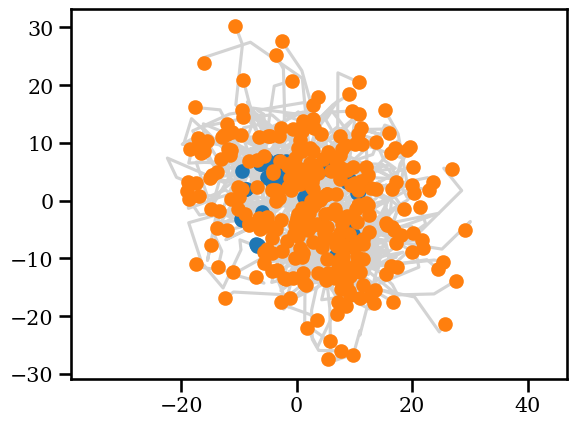

In [7]:
viewer.draw_reference_trajectories()

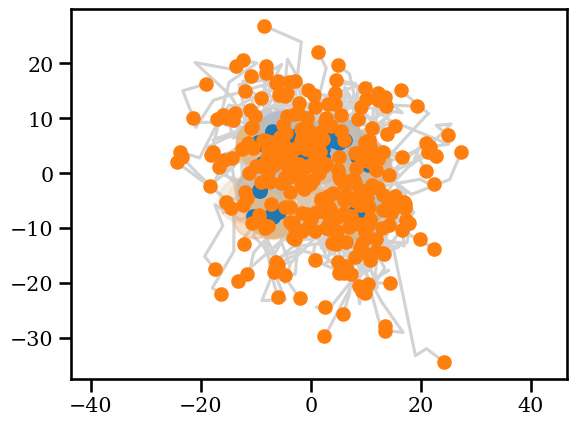

In [8]:
viewer.draw_extreme_marginals()
viewer.draw_reference_trajectories()

In [10]:
viewer.interactive_f_gradient_flow()

interactive(children=(FloatSlider(value=0.3, description='probe_time', max=1.0, step=0.05), Output()), _dom_cl…

<function viewer.Viewer.interactive_f_gradient_flow.<locals>.gradient_flow(probe_time)>

In [11]:
antigen_pca = joblib.load(f"{CovidDataset.get_dataset_name()}_antigen_pca.joblib")

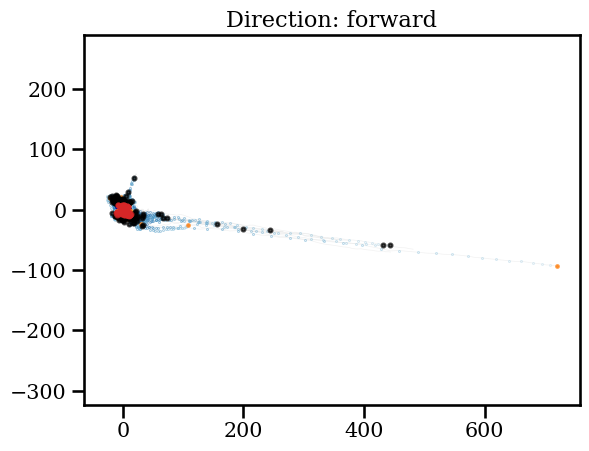

Dead particles. End=0.546 	 Min=0.312 	 Max=0.552


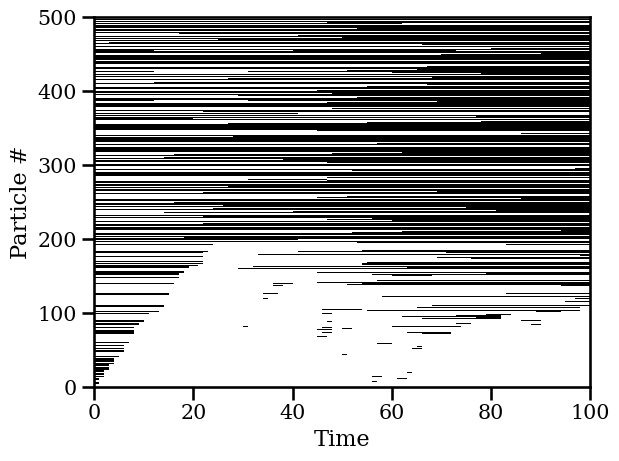

In [14]:
cov_f_trajs, cov_f_ys, cov_f_statuses = viewer.draw_trajectories(FORWARD, samples_num=500, timesteps_num=100)

In [18]:
variant_embs = CovidDataset.load_variant_embs()

In [19]:
# for var_name, var_emb in {k: variant_embs[k] for k in list(set(variant_embs.keys()))}.items():
#     plt.scatter(*var_emb.T[:2], marker="X" if var_name == "wt" else ".", label=var_name)
# plt.legend();

In [20]:
@ipywidgets.interact(k=ipywidgets.IntSlider(value=20, min=0, max=100))
def interactive_antigen_pos(k):
    antigen_proj = cov_f_trajs[k,cov_f_statuses[k],2:4]
    plt.scatter(*antigen_proj.T)

    for var_name, var_emb in {k: variant_embs[k] for k in list(set(variant_embs.keys()))}.items():
        plt.scatter(*var_emb.T[:2], marker="X" if var_name == "wt" else ".", label=var_name)
    plt.legend();

interactive(children=(IntSlider(value=20, description='k'), Output()), _dom_classes=('widget-interact',))

In [21]:
key_interactive_killing = random.PRNGKey(0)

eval_ferryman = Viewer(key_interactive_killing, covid_experiment).eval_ferryman(FORWARD)

@ipywidgets.interact(k=ipywidgets.IntSlider(value=20, min=0, max=100))
def interactive_killing_rate(k, prior=False):
    global key_interactive_killing

    pos = cov_f_trajs[k,cov_f_statuses[k],:]

    if prior:
        traj_kr = covid_experiment.sde.killer(k/100, pos)
    else:
        key_interactive_killing, traj_kr = covid_experiment.sde.reweight_killing(key_interactive_killing, FORWARD, covid_experiment.sde.killer(k/100, pos), eval_ferryman, cov_f_trajs[k], cov_f_statuses[k], k/100, pos)

    plt.scatter(*pos.T[:2], c=traj_kr, cmap="RdBu_r")
    plt.colorbar();

interactive(children=(IntSlider(value=20, description='k'), Checkbox(value=False, description='prior'), Output…

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
focus_countries = ["United States", "United Kingdom", "Germany", "Denmark", "Canada", "Japan", "France", "Sweden", "Switzerland", "Brazil", "India", "Netherlands", "Italy", "Turkey", "Spain", "Belgium", "Ireland", "Slovenia", "Mexico", "Poland", "South Africa"]
focus_continent = ["Americas",      "Europe",         "Europe",  "Europe",  "Americas","Asia", "Europe", "Europe", "Europe",      "Americas","Asia", "Europe",      "Europe","Europe", "Europe","Europe",  "Europe",  "Europe",   "Americas","Europe", "Africa"]
country_embs = pd.read_csv(f"{CovidDataset.get_dataset_name()}_country_embs.csv", index_col=0).rename_axis("location", axis=0).loc[focus_countries]

In [25]:
country_embs

,x0,x1
location,,
United States,8.005851,-7.559977
United Kingdom,-0.969683,3.615122
Germany,-5.607405,6.878341
Denmark,-1.421538,5.501215
Canada,9.125320,-5.678816
Japan,-6.972890,-7.717238
France,4.802838,6.051257
Sweden,0.681980,5.062044
Switzerland,3.959145,6.190360


In [26]:
ground_truth_evolution = CovidDataset.load_ground_truth_evolution()

common_countries = country_embs.join(ground_truth_evolution, how="inner").index.get_level_values(0).unique().to_numpy()
common_countries

array(['Belgium', 'Brazil', 'Canada', 'Denmark', 'France', 'Germany',
       'India', 'Ireland', 'Italy', 'Japan', 'Mexico', 'Netherlands',
       'Poland', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Turkey', 'United Kingdom', 'United States'],
      dtype=object)

In [27]:
country_knn = KNeighborsClassifier(weights='distance')
country_knn.fit(country_embs.to_numpy(), range(country_embs.shape[0]))

KNeighborsClassifier(weights='distance')

,MMD_distance
SB,0.23462948
2nd_order_approx,0.25562263
1st_order_approx,0.29694784


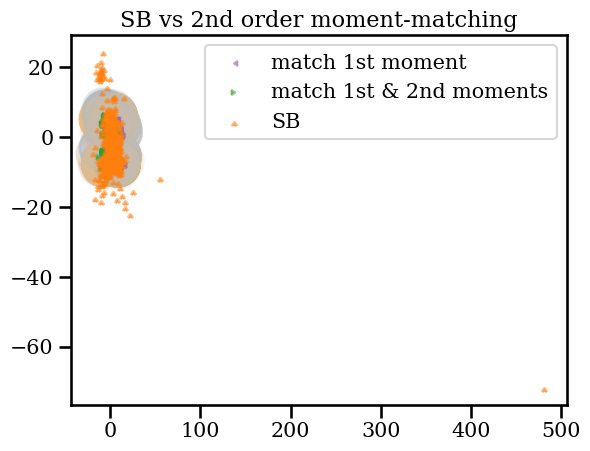

In [28]:
viewer.compare_with_baselines()

In [29]:
cov_f_trajs.shape

(100, 500, 6)

In [30]:
variant_names = covid_experiment.e.variant_names

variant_knn = KNeighborsClassifier(1)

variants_matrix = jnp.concatenate([covid_experiment.e.antigen_embs[var_name] for var_name in variant_names], axis=0)

variant_knn.fit(variants_matrix, range(variant_names.shape[0]))

KNeighborsClassifier(n_neighbors=1)

In [31]:
viewer.get_fresh_marginal(FORWARD).mean(axis=0)

Array([ 2.339807  , -0.7573322 ,  4.160969  , -2.5609264 , -1.41011   ,
       -0.45093167], dtype=float32)

In [32]:
[covid_experiment.e.antigen_embs[var_name] for var_name in variant_names]

[array([[ 3.77825921, -5.80487595, -6.18733067, -2.8629897 ]]),
 array([[  4.72444287,  -9.63358009, -12.62482485,   8.55478501]]),
 array([[-15.99872389,  16.24601287,  15.19398206, -19.36283252]]),
 array([[  1.29823616,  -8.4725903 , -10.44953609,   8.45690187]]),
 array([[ 6.19778564,  7.66503201, 14.06770898,  5.21413635]])]

In [33]:
def traj_to_variant(embs, return_names=False):
    if len(embs.shape) == 2:
        preds = variant_knn.predict(embs[...,2:])
    else:
        preds = variant_knn.predict(embs[...,2:].reshape((-1,embs.shape[-1]-2))).reshape(embs.shape[:-1])

    if return_names:
        return variant_names[preds.ravel()].reshape(preds.shape)
    else:
        return preds

In [34]:
def traj_to_mix(trajs, status=None):
    pred_variants = traj_to_variant(trajs)

    if status is not None:
        pred_variants = pred_variants * status + jnp.logical_not(status) * (-1)

    variant_counts = [(pred_variants == i).sum(axis=-1) for i in range(variant_names.shape[0])]

    counts = jnp.stack(variant_counts, axis=-1)

    return counts / counts.sum(axis=-1, keepdims=True)

In [35]:
covid_experiment.e.killing_function_name

'delta_evolution'

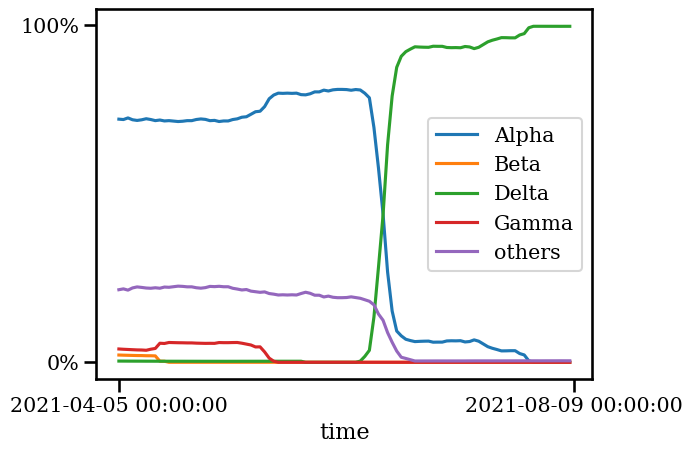

In [36]:
for var_frac, var_name in zip(traj_to_mix(cov_f_trajs, cov_f_statuses).T, variant_names):
    plt.plot(var_frac, label=var_name);
    plt.legend();

plt.yticks([0, 1.], ['0%', '100%'])
plt.xticks([0, 100], [covid_experiment.e.init_date, covid_experiment.e.end_date])

plt.xlabel("time");

export_fig("usb_covid_variant_mix_evo")

In [37]:
# plt.plot(jnp.linspace(0, 100, 10), ground_truth_evolution.query("location in @focus_countries").groupby("date").agg("mean").to_numpy());
# for var_frac, var_name in zip(traj_to_mix(cov_f_trajs, cov_f_statuses).T, variant_names):
#     plt.plot(var_frac, label=var_name);
#     plt.legend();

In [38]:
def soft_traj_to_mix(trajs, status=None):
    pred_sim = -vmap(vmap(lambda x, s: jnp.sqrt(jnp.square(jnp.expand_dims(x, axis=0) - variants_matrix).sum(axis=-1)) if s else jnp.ones((len(variant_names),)) * 1000., in_axes=(0,0)), in_axes=(1,1))(trajs[...,2:], status)  # shape: (k,n,v)

    raw_mix = (pred_sim - pred_sim.min(axis=-1, keepdims=True))
    mix = raw_mix / raw_mix.sum(axis=-1, keepdims=True)

    return mix.mean(axis=1)

In [39]:
# for var_frac, var_name in zip(soft_traj_to_mix(cov_f_trajs, cov_f_statuses).T, variant_names):
#     plt.plot(var_frac, label=var_name);
#     plt.legend();

# plt.yticks([0, 1.], ['0%', '100%'])
# plt.xticks([0, 100], [covid_experiment.e.init_date, covid_experiment.e.end_date])

# plt.xlabel("time");

In [40]:
variants = list(zip(variant_names, range(variant_names.shape[0])))

In [41]:
@ipywidgets.interact(cov_variant=ipywidgets.Dropdown(value=2, options=variants), t=ipywidgets.FloatSlider(value=.0, min=0., max=1., step=.05))
def interactive_track_prevalent_variant(cov_variant, t):
    k = int(t*100)
    prevanent_idx = (traj_to_variant(cov_f_trajs[k]) == cov_variant)
    prevalent_locs = cov_f_trajs.at[k,prevanent_idx,:2].get()

    viewer.draw_extreme_marginals()
    plt.scatter(*prevalent_locs.T, alpha=.2)

    plt.xlim((cov_f_trajs[:,:,0].min(), cov_f_trajs[:,:,0].max()))
    plt.ylim((cov_f_trajs[:,:,1].min(), cov_f_trajs[:,:,1].max()))

interactive(children=(Dropdown(description='cov_variant', index=2, options=(('Alpha', 0), ('Beta', 1), ('Delta…

In [42]:
@ipywidgets.interact(cov_variant=ipywidgets.Dropdown(value=2, options=variants), t=ipywidgets.FloatSlider(value=.0, min=0., max=1., step=.05))
def interactive_track_prevalent_variant(cov_variant, t):
    k = int(t*100)
    prevanent_idx = (traj_to_variant(cov_f_trajs[k]) == cov_variant)
    prevalent_locs = cov_f_trajs.at[k,prevanent_idx,:2].get()

    if prevalent_locs.shape[0] > 0:
        prevalent_country_idxs, prevalent_country_counts = jnp.unique(country_knn.predict(prevalent_locs), return_counts=True)

        prevalent_country_idxs = prevalent_country_idxs[jnp.argsort(prevalent_country_counts)][-5:]

        for ct_idx in prevalent_country_idxs:
            ct = country_embs.index.to_numpy()[ct_idx]
            plt.text(*country_embs.loc[ct], ct)

    viewer.draw_extreme_marginals()
    plt.scatter(*prevalent_locs.T, alpha=.2)

    plt.xlim((cov_f_trajs[:,:,0].min(), cov_f_trajs[:,:,0].max()))
    plt.ylim((cov_f_trajs[:,:,1].min(), cov_f_trajs[:,:,1].max()))

interactive(children=(Dropdown(description='cov_variant', index=2, options=(('Alpha', 0), ('Beta', 1), ('Delta…

In [43]:
country_sequence_nums = CovidDataset.load_sequence_nums(global_stats=False)
all_country_embs = CovidDataset.load_country_embs()

@ipywidgets.interact(cov_variant=ipywidgets.Dropdown(value=2, options=variants), k=ipywidgets.IntSlider(value=0, min=0, max=ground_truth_evolution.index.get_level_values(1).unique().shape[0]-1))
def evo_by_country(cov_variant, k):
    k_date = ground_truth_evolution.index.get_level_values(1).unique()[k]
    prevanent_countries_mask = ground_truth_evolution.loc[common_countries].swaplevel(0, 1).loc[k_date].apply(lambda row: jnp.argmax(row.to_numpy()), axis=1)
    prevanent_countries = prevanent_countries_mask[prevanent_countries_mask == cov_variant].index

    prevalent_seq_counts = country_sequence_nums.loc[prevanent_countries, k_date]

    prevalent_locs = all_country_embs.loc[prevanent_countries]

    viewer.draw_extreme_marginals()
    plt.scatter(*prevalent_locs.to_numpy().T, s=prevalent_seq_counts / country_sequence_nums[k_date].max() * 200)

    plt.xlim((cov_f_trajs[:,:,0].min(), cov_f_trajs[:,:,0].max()))
    plt.ylim((cov_f_trajs[:,:,1].min(), cov_f_trajs[:,:,1].max()))

interactive(children=(Dropdown(description='cov_variant', index=2, options=(('Alpha', 0), ('Beta', 1), ('Delta…

In [44]:
country_embs_array = jnp.stack(country_embs.apply(lambda x: x.to_numpy(), axis=1)) # type: ignore
def close_to_countries(pos):
    country_dist = vmap(lambda x: jnp.sqrt(jnp.square(x.reshape((1,-1)) - country_embs_array).sum(axis=-1)).min(axis=0))(pos)
    country_closeness = jnp.clip(3.5 - country_dist, 0.)
    return country_closeness

In [45]:
def plot_kde_cover(points, kde_var=.9, mins=None, maxs=None, norm_factor=1., focus=True, **kwargs):
    if mins is None:
        mins = points.min(axis=0)
    
    if maxs is None:
        maxs = points.max(axis=0)

    xx, yy = jnp.mgrid[mins[0]:maxs[0]:40j, mins[1]:maxs[1]:40j]

    sample_points = jnp.stack([xx.ravel(), yy.ravel()]).T

    kde_estimates = kde(gaussian_kernel(kde_var), points, sample_points).reshape(xx.shape)
    kde_estimates *= norm_factor / kde_estimates.max()

    if focus:
        kde_estimates = kde_estimates * close_to_countries(sample_points).reshape(xx.shape)

    plt.pcolormesh(xx, yy, kde_estimates, vmin=0., vmax=1., **kwargs)

    return kde_estimates

In [46]:
# def plot_ground_truth_prevalence(cov_variant, k):
#     possible_dates = ground_truth_evolution.index.get_level_values(1).unique()

#     next_step_date = covid_experiment.e.init_date + (((k+5)/100) * (covid_experiment.e.end_date - covid_experiment.e.init_date))
#     # print(next_step_date)

#     # Take the most recent date that comes before the next frame
#     k_date = possible_dates[possible_dates < next_step_date][-1]

#     prevanent_countries_mask = ground_truth_evolution.loc[common_countries].swaplevel(0, 1).loc[k_date].apply(lambda row: jnp.argmax(row.to_numpy()), axis=1)
#     prevanent_countries = prevanent_countries_mask[prevanent_countries_mask == cov_variant].index

#     prevalent_seq_counts = country_sequence_nums.loc[prevanent_countries, k_date]

#     prevalent_locs = all_country_embs.loc[prevanent_countries]

#     plt.scatter(*prevalent_locs.to_numpy().T, s=prevalent_seq_counts / country_sequence_nums[k_date].max() * 200, color=palette[1], alpha=.5)


def plot_ground_truth_prevalence(cov_variant, k):
    possible_dates = ground_truth_evolution.index.get_level_values(1).unique()

    # next_step_date = covid_experiment.e.init_date + (((k)/100) * (covid_experiment.e.end_date - covid_experiment.e.init_date))
    # # print(next_step_date)

    # # Take the most recent date that comes before the next frame
    # k_date = possible_dates[possible_dates < next_step_date][-1]

    next_step_date = covid_experiment.e.init_date + ((k/100) * (covid_experiment.e.end_date - covid_experiment.e.init_date))

    # Take the most recent date that comes before
    k_date = possible_dates[possible_dates <= next_step_date][-1]


    prevalent_seq_counts = ground_truth_evolution.loc[focus_countries].swaplevel(1,0).loc[k_date].iloc[:,cov_variant] * country_sequence_nums.loc[focus_countries, k_date]

    prevalent_locs = all_country_embs.loc[focus_countries]

    plt.scatter(*prevalent_locs.to_numpy().T, s=prevalent_seq_counts / country_sequence_nums.loc[focus_countries,k_date].max() * 200, color="black", alpha=.5)

In [47]:
# variant_prevalence_cmap = LinearSegmentedColormap.from_list("variant_prevalence", colors=["#FFFFFF", palette[3]], N=10)
variant_prevalence_cmap = LinearSegmentedColormap.from_list("variant_prevalence", colors=["#FFFFFF","#2ca02c"], N=10)
# plt.scatter([0,1], [0,1], c=variant_prevalence_cmap(jnp.array([0., 1.])))

In [48]:
@ipywidgets.interact(cov_variant=ipywidgets.Dropdown(value=2, options=variants), k=ipywidgets.IntSlider(min=1, max=100, value=10, step=1))
def interactive_plot_delta_preds(cov_variant, k):
    prevanent_idx = (traj_to_variant(cov_f_trajs[k]) == cov_variant) * cov_f_statuses[k]
    prevalent_locs = cov_f_trajs[k,prevanent_idx,:2]

    if prevalent_locs.shape[0] > 0:
        plot_kde_cover(prevalent_locs, kde_var=2., mins=(-20, -12), maxs=(20, 10), norm_factor=prevalent_locs.shape[0]/prevanent_idx.shape[0], cmap=variant_prevalence_cmap)
        plt.colorbar()

    plot_ground_truth_prevalence(cov_variant, k)

    for ct_name in focus_countries:
        ct_emb = country_embs.loc[ct_name]
        plt.text(*ct_emb, ct_name, fontsize=10)
    
    # plt.xlim((cov_f_trajs[...,0].min(), cov_f_trajs[...,0].max()))
    # plt.ylim((cov_f_trajs[...,1].min(), cov_f_trajs[...,1].max()))

    plt.axis("auto")

    plt.axis("off")

interactive(children=(Dropdown(description='cov_variant', index=2, options=(('Alpha', 0), ('Beta', 1), ('Delta…

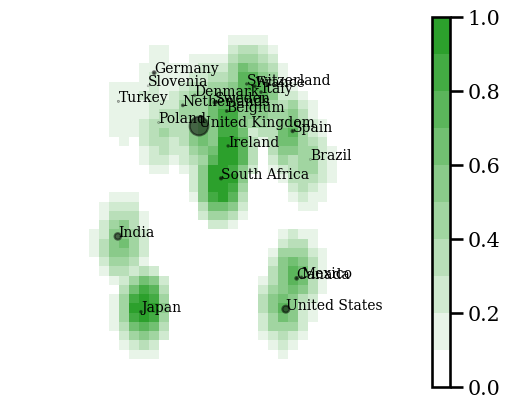

In [49]:
interactive_plot_delta_preds(2, 63)
export_fig("usb_covid_delta_prevalence_90")

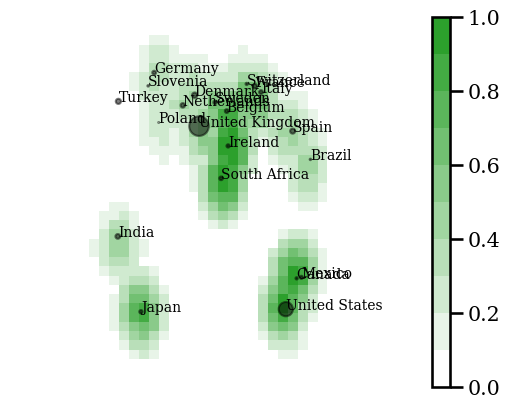

In [50]:
interactive_plot_delta_preds(2, 85)
export_fig("usb_covid_delta_prevalence_85")

In [51]:
.85 * (CovidDataset.end_date - CovidDataset.init_date) + CovidDataset.init_date

datetime.datetime(2021, 7, 21, 2, 24)

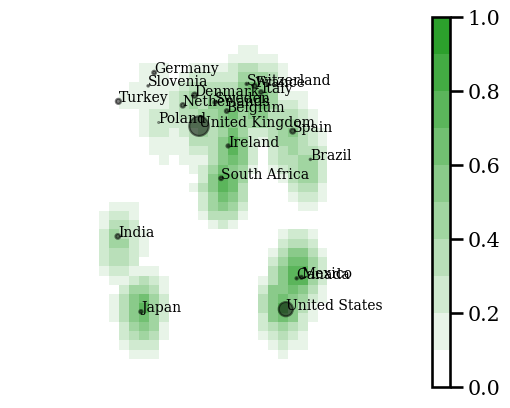

In [52]:
interactive_plot_delta_preds(2, 80)
export_fig("usb_covid_delta_prevalence_80")

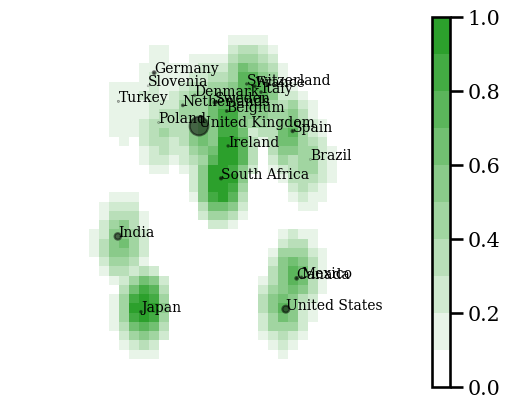

In [53]:
interactive_plot_delta_preds(2, 63)
export_fig("usb_covid_delta_prevalence_63")

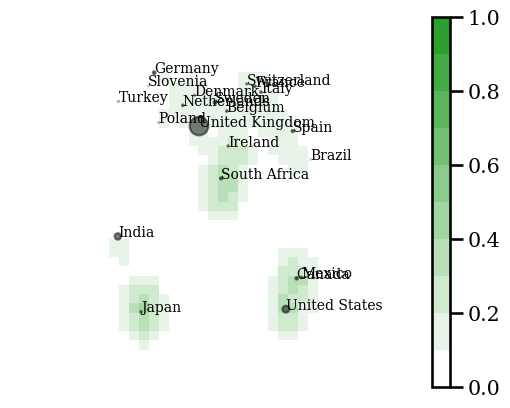

In [54]:
interactive_plot_delta_preds(2, 57)
export_fig("usb_covid_delta_prevalence_57")

In [55]:
.57 * (CovidDataset.end_date - CovidDataset.init_date) + CovidDataset.init_date

datetime.datetime(2021, 6, 15, 19, 40, 48)

#### Geographic predictions

In [56]:
continent_coords = pd.DataFrame(focus_continent, index=focus_countries, columns=["continent"]).join(country_embs).groupby('continent').agg(list)
spare_margin = .5
continent_margins = pd.concat([
    continent_coords.applymap(lambda l: min(l)).rename_axis("coord", axis=1).T.reset_index().set_axis(["min"]*2).set_index("coord", append=True) - spare_margin,
    continent_coords.applymap(lambda l: max(l)).rename_axis("coord", axis=1).T.reset_index().set_axis(["max"]*2).set_index("coord", append=True) + spare_margin
]).T
continent_margins

min                  max          
coord            x0        x1         x0        x1
continent                                         
Africa     0.810241 -0.072668   1.810241  0.927332
Americas   7.505851 -8.059977  11.044618  2.081494
Asia      -9.865047 -8.217238  -6.472890 -2.618266
Europe    -9.806771  1.904343   9.211655  7.378341

In [57]:
def get_variant_by_continent_predictions(continent, cov_variant):
    prevanent_idx = (traj_to_variant(cov_f_trajs) == cov_variant) * cov_f_statuses
    pos = cov_f_trajs[:,:,:2]
    continent_mask = (continent_margins.loc[continent,'min'].to_numpy().reshape((-1,2)) <= pos).all(axis=-1) * (pos <= continent_margins.loc[continent,'max'].to_numpy().reshape((-1,2))).all(axis=-1) * cov_f_statuses

    variant_in_continent_mask = prevanent_idx * continent_mask

    return variant_in_continent_mask.sum(axis=1) / continent_mask.sum(axis=1)

In [58]:
def plot_variant_by_continent(continent, cov_variant):
    variant_in_continent_preds = get_variant_by_continent_predictions(continent, cov_variant)

    plt.plot(pd.date_range(covid_experiment.e.init_date, covid_experiment.e.end_date, 100), variant_in_continent_preds)
    ground_truth_evolution.loc[pd.DataFrame({'country': focus_countries, 'continent': focus_continent}).groupby('continent').agg(list).loc[continent, "country"]].iloc[:,cov_variant].groupby("date").agg('mean').plot(style='--', ax=plt.gca())

In [59]:
ipywidgets.interact(cov_variant=ipywidgets.Dropdown(value=2, options=variants))(lambda cov_variant: plot_variant_by_continent("Europe", cov_variant))

interactive(children=(Dropdown(description='cov_variant', index=2, options=(('Alpha', 0), ('Beta', 1), ('Delta…

<function __main__.<lambda>(cov_variant)>

In [60]:
# np.save("../reproducibility/covid_v4_preds_europe.npy", get_variant_by_continent_predictions("Europe", 2))

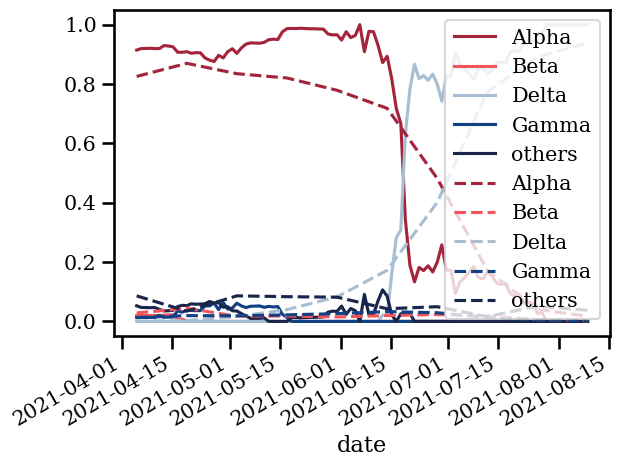

In [61]:
tmp_continent = "Europe"
pd.DataFrame({v_name: get_variant_by_continent_predictions(tmp_continent, v_num) for (v_name, v_num) in variants}, index=pd.date_range(covid_experiment.e.init_date, covid_experiment.e.end_date, 100)).plot(color=palette[::-1])
ground_truth_evolution.loc[pd.DataFrame({'country': focus_countries, 'continent': focus_continent}).groupby('continent').agg(list).loc[tmp_continent, "country"]].groupby("date").agg('mean').plot(style='--', ax=plt.gca(), color=palette[::-1]);

export_fig("usb_covid_pred_europe")